In [1]:
import sys
import os
import torch
import pickle
from matplotlib import pyplot as plt
from torchinfo import summary
import numpy as np

from src.models import helpers
from src.models.model import Model
from src.models.loops import test_loop
from src.models.municipalities import MUNICIPALITIES

# appending model path for pickle
sys.path.append('src/models')

In [2]:
# MODEL
NAME = "wind_pressurenew"
MODEL_PATH = f"models/{NAME}/"

In [4]:
model_dict = torch.load(MODEL_PATH + "model.pt")

with open(MODEL_PATH + "test.pkl", "rb") as f:
    test_loader = pickle.load(f)

num_features, num_target = helpers.get_num_input_output(test_loader)

input_dicts = []
for xs in num_features:
    input = {
        "NUM_FEATURES": xs,
        "OUTPUT_UNITS": 32,
        "DROPOUT": 0.1,
    }
    input_dicts.append(input)

model = Model(num_target, *input_dicts)
model.load_state_dict(model_dict)


<All keys matched successfully>

In [5]:
loss_fn = torch.nn.MSELoss(reduction="none")
avg_test_error, municipaliy_error = test_loop(test_loader, model, loss_fn)


Test Error: 
 Avg MWh: 3.098733


In [12]:
# get example prediction
*X, y = next(iter(test_loader))
model.eval()
pred = model(*X)

example_idx = 1
single_example_pred = pred[example_idx]
single_example_ground_truth = y[example_idx]

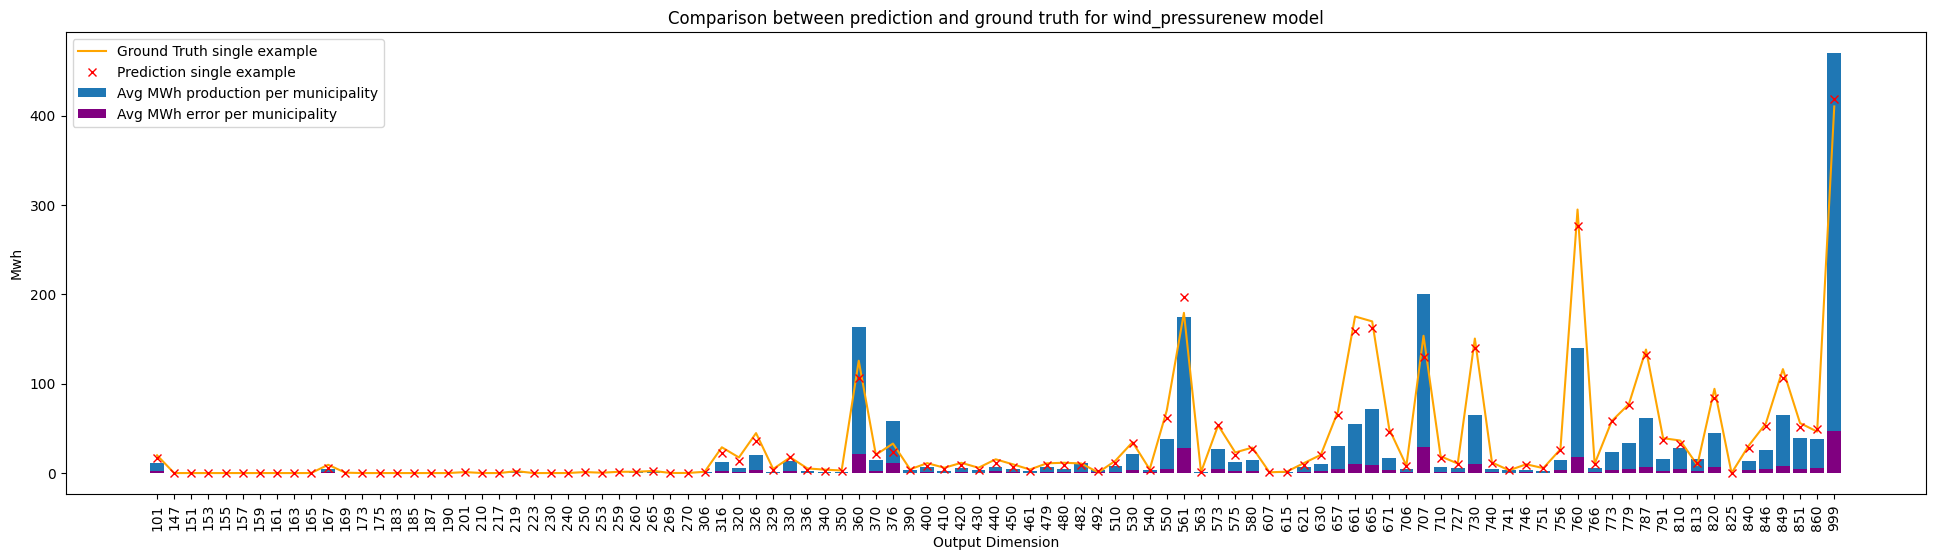

In [13]:
# plot example
plt.figure(figsize=(24, 6))

# Plotting ground truth bars
plt.plot(
    np.arange(len(single_example_ground_truth)),
    single_example_ground_truth,
    label="Ground Truth single example",
    color="orange",
)

plt.xticks(np.arange(len(single_example_ground_truth)), MUNICIPALITIES, rotation=90)
# Plotting prediction markers
plt.plot(
    np.arange(len(single_example_pred)),
    single_example_pred.detach().numpy(),
    "rx",
    label="Prediction single example",
)


plt.bar(
    np.arange(len(single_example_pred)),
    torch.mean(y, dim=0).detach().numpy(),
    label="Avg MWh production per municipality",
)

plt.bar(
    np.arange(len(single_example_pred)),
    municipaliy_error[0],
    label="Avg MWh error per municipality",
    color="purple",
)


plt.xlabel("Output Dimension")
plt.ylabel("Mwh")
plt.title(f"Comparison between prediction and ground truth for {NAME} model")
plt.legend()
plt.show()
